In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import random
from tqdm import *

In [2]:
runner = pd.read_csv("../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../output/data_clean/cleaned_race_equivalent_distance.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)
runner.gender = pd.Categorical(
    runner.gender, categories=['M','W'],ordered=False
)
runner.nationality = pd.Categorical(
    runner.nationality, categories=runner.nationality.unique(),ordered=False
)
race.event = pd.Categorical(
    race.event, categories=race.event.unique(), ordered=False
)
race.country_code = pd.Categorical(
    race.country_code, categories=race.country_code.unique(), ordered=False
)
race.participation = pd.Categorical(
    race.participation, categories=race.participation.unique(), ordered=False
)
#runner = runner.dropna()
race = race.assign(
    date = pd.to_datetime(race[['month', 'day', 'year']])
)
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]
join = join.assign(
    relative_ranking = join.ranking / join.frequency_in_ranking
)
join.race_year_id = pd.Categorical(
    join.race_year_id, categories=join.race_year_id.unique(), ordered=False
)
join.runner = pd.Categorical(
    join.runner, categories=join.runner.unique(), ordered=False
)

In [3]:
join = join.assign(
    age_range_cat = join.age_range.cat.codes,
    country_cat = join.country_code.cat.codes,
    gender_cat = join.gender.cat.codes,
    nationality_cat = join.nationality.cat.codes,
    event_cat = join.event.cat.codes,
    country_code_cat = join.country_code.cat.codes,
    participation_cat = join.participation.cat.codes,
    race_year_id_cat = join.race_year_id.cat.codes,
    runner_cat = join.runner.cat.codes,
    finished = ~join.time_in_seconds.isna()
)
join = join.drop(columns=['ranking',
                          'time', 
                          'time_in_seconds', 
                          'speed',
                          'equivalent_speed',
                          'relative_ranking',
                          'runner',
                          'race',
                          'country', 
                          'gender',
                          'nationality',
                          'event',
                          'country_code',
                          'participation',
                          'race_year_id',
                          'runner_id',
                          'age_range',
                          'date',
                          'age_range_cat',
                          'runner_cat',
                          'age'])

In [4]:
join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128749 entries, 0 to 130136
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   age_course            128749 non-null  float64
 1   distance              128749 non-null  float64
 2   elevation_gain        128749 non-null  float64
 3   elevation_loss        128749 non-null  float64
 4   aid_stations          128749 non-null  int64  
 5   participants          128749 non-null  int64  
 6   year                  128749 non-null  int64  
 7   month                 128749 non-null  int64  
 8   day                   128749 non-null  int64  
 9   frequency_in_ranking  128749 non-null  int64  
 10  equivalent_distance   128749 non-null  float64
 11  weighted_elevation    128749 non-null  float64
 12  country_cat           128749 non-null  int8   
 13  gender_cat            128749 non-null  int8   
 14  nationality_cat       128749 non-null  int16  
 15  

In [5]:
X = join.iloc[:, :-1]
y = join.iloc[:, -1]

In [6]:
X

,age_course,distance,elevation_gain,elevation_loss,aid_stations,participants,year,month,day,frequency_in_ranking,equivalent_distance,weighted_elevation,country_cat,gender_cat,nationality_cat,event_cat,country_code_cat,participation_cat,race_year_id_cat
0,30.0,166.9,4520.0,-4520.0,10,150,2021,9,3,25,212.1,0.213107,0,0,0,0,0,0,0
1,43.0,166.9,4520.0,-4520.0,10,150,2021,9,3,25,212.1,0.213107,0,0,0,0,0,0,0
2,38.0,166.9,4520.0,-4520.0,10,150,2021,9,3,25,212.1,0.213107,0,0,0,0,0,0,0
3,55.0,166.9,4520.0,-4520.0,10,150,2021,9,3,25,212.1,0.213107,0,1,0,0,0,0,0
4,48.0,166.9,4520.0,-4520.0,10,150,2021,9,3,25,212.1,0.213107,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130132,61.0,161.0,7620.0,-7620.0,0,46,2012,1,14,46,237.2,0.321248,11,0,1,135,11,0,1132
130133,45.0,161.0,7620.0,-7620.0,0,46,2012,1,14,46,237.2,0.321248,11,1,29,135,11,0,1132
130134,46.0,161.0,7620.0,-7620.0,0,46,2012,1,14,46,237.2,0.321248,11,0,29,135,11,0,1132
130135,49.0,161.0,7620.0,-7620.0,0,46,2012,1,14,46,237.2,0.321248,11,0,1,135,11,0,1132


<AxesSubplot:>

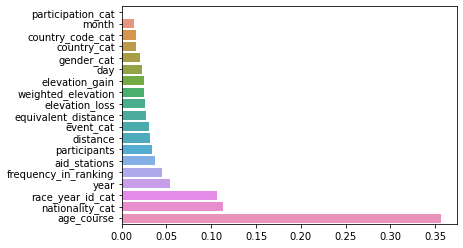

In [7]:
random.seed(149)
cls = RandomForestClassifier()
cls.fit(X, y)
importance = cls.feature_importances_
features = ["age_course",
            "distance",
            "elevation_gain",
            "elevation_loss",
            "aid_stations",
            "participants",
            "year",
            "month",
            "day",
            "frequency_in_ranking",
            "equivalent_distance",
            "weighted_elevation",
            "country_cat",
            "gender_cat",
            "nationality_cat",
            "event_cat",
            "country_code_cat",
            "participation_cat",
            "race_year_id_cat"]
df_importance = pd.DataFrame({'features':features,'importance':importance})
df_importance = df_importance.sort_values(by = ['importance'], ascending = False)
sns.barplot(x = importance, y = features, data = df_importance, order=df_importance.sort_values('importance').features)

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score

In [35]:
def cross_validation(X, y, n_folds):
    n = (n_folds - 1) / n_folds * len(y)
    cls = LogisticRegression(random_state=0, max_iter = 10000).fit(X, y)
    accuracies = [i for i in cross_val_score(cls, X, y, cv = n_folds)]
    return max(accuracies)
        

In [30]:
def incremental_logit(importance_df, X, y):
    importance_df = importance_df.sort_values('importance', ascending=False)
    incr_logit_score = pd.DataFrame()
    
    for i in tqdm(range(len(importance_df))):
        accuracy = cross_validation(X.iloc[:,:i+1], y, 10)
        incr_logit_score = incr_logit_score.append({
                                'variable':X.columns[i],
                                 'accuracy':accuracy
                                }, ignore_index=True)
        
    return incr_logit_score
    
res = incremental_logit(df_importance,X,y)

100%|███████████████████████████████████████████| 19/19 [05:58<00:00, 18.88s/it]


<AxesSubplot:ylabel='accuracy'>

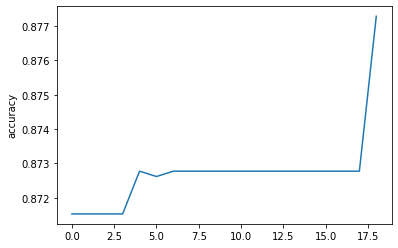

In [31]:
sns.lineplot(
    x = res.index,
    y = "accuracy",
    data = res,
    err_style="bars", ci="sd",
)

In [64]:
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
logreg=LogisticRegression(max_iter = 10000)
predicted = cross_val_predict(logreg, X, y, cv=10)
print(metrics.accuracy_score(y, predicted))
print(metrics.classification_report(y, predicted))

0.8133189383995215
              precision    recall  f1-score   support

       False       0.13      0.08      0.10     16545
        True       0.87      0.92      0.90    112204

    accuracy                           0.81    128749
   macro avg       0.50      0.50      0.50    128749
weighted avg       0.78      0.81      0.79    128749

